# Inteligência Artificial 2025-1
## Previsão do Nível do Rio do Sul com Regressão Linear

**Aluno:** Seu Nome Completo
**GitHub:** https://github.com/giancraft/Analise-Nivel-Rio-ML

---

### Introdução

Este projeto visa desenvolver um modelo de regressão linear para prever o nível do Rio Itajaí-Açu na cidade de Rio do Sul, um dado crucial para a gestão de riscos e alertas de enchentes. Para isso, utilizaremos um dataset real contendo dados históricos do nível do rio em Rio do Sul, bem como os níveis e os índices de chuva de cidades vizinhas (Ituporanga e Taió), que estão a montante e influenciam diretamente no volume de água.

O notebook seguirá as etapas obrigatórias do trabalho, incluindo a limpeza dos dados, análise exploratória, pré-processamento, treinamento, avaliação de diferentes modelos e, por fim, a criação de uma aplicação para uso prático.

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Leitura e Análise Inicial dos Dados

Nesta primeira etapa, vamos carregar o dataset, verificar sua estrutura e realizar uma limpeza inicial para garantir a qualidade dos dados que serão utilizados no treinamento do modelo.

In [2]:
# 1.1 Carregue o dataset
try:
    df = pd.read_csv('dados_rio_e_chuva.csv')
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'dados_rio.csv' não encontrado. Certifique-se de que ele está na pasta correta.")

df.head()

Dataset carregado com sucesso!


,NivelRiodoSul,NívelItuporanga,ChuvaItuporanaga,NívelTaió,ChuvaTaió
0,"170,0","30,0","3,0","98,0","0,0"
1,"170,0","39,0","12,0","98,0","0,0"
2,"169,0","59,0","19,0","98,0","0,0"
3,"169,0","82,0","5,0","98,0","0,0"
4,"169,0","27,0","1,0","97,0","0,0"


In [3]:
# --- CORREÇÃO: Padronizando os nomes das colunas ---

# Primeiro, vamos ver os nomes originais das colunas para confirmar
print("Nomes originais das colunas:", df.columns.tolist())

# Criando um dicionário para renomear as colunas para um formato padrão
colunas_novas = {
    'NivelRiodoSul': 'nivel_rio_do_sul',
    'NívelItuporanga': 'nivel_ituporanga',
    'ChuvaItuporanaga': 'chuva_ituporanga', 
    'NívelTaió': 'nivel_taio',
    'ChuvaTaió': 'chuva_taio'
}

# Renomeando as colunas no DataFrame
df.rename(columns=colunas_novas, inplace=True)

print("\nNomes das colunas após padronização:", df.columns.tolist())
df.head()

Nomes originais das colunas: ['NivelRiodoSul', 'NívelItuporanga', 'ChuvaItuporanaga', 'NívelTaió', 'ChuvaTaió']

Nomes das colunas após padronização: ['nivel_rio_do_sul', 'nivel_ituporanga', 'chuva_ituporanga', 'nivel_taio', 'chuva_taio']


,nivel_rio_do_sul,nivel_ituporanga,chuva_ituporanga,nivel_taio,chuva_taio
0,"170,0","30,0","3,0","98,0","0,0"
1,"170,0","39,0","12,0","98,0","0,0"
2,"169,0","59,0","19,0","98,0","0,0"
3,"169,0","82,0","5,0","98,0","0,0"
4,"169,0","27,0","1,0","97,0","0,0"


#### 1.2 Limpeza e Preparação dos Dados

Antes da análise, é fundamental garantir que os dados estejam no formato correto e sem inconsistências. Isso envolve a conversão de tipos de dados (pois os dados numéricos com vírgula são lidos como texto), o tratamento de valores faltantes e de duplicatas.

In [4]:
# Lista de todas as colunas que devem ser numéricas
colunas_numericas = ['nivel_rio_do_sul', 'nivel_ituporanga', 'chuva_ituporanga', 'nivel_taio', 'chuva_taio']

# Loop para corrigir o separador decimal e converter para tipo numérico
for coluna in colunas_numericas:
    # Verifica se a coluna é do tipo 'object' (texto)
    if df[coluna].dtype == 'object':
        # Substitui a vírgula pelo ponto
        df[coluna] = df[coluna].str.replace(',', '.', regex=False)
        # Converte a coluna para o tipo numérico. 'coerce' transforma erros em NaN (Not a Number)
        df[coluna] = pd.to_numeric(df[coluna], errors='coerce')

print("Tipos de dados após a conversão:")
print(df.dtypes)
print("\n")

# Agora, tratamos valores faltantes (que podem ter sido gerados na conversão) e duplicatas.

# Verificando valores faltantes
print("Valores faltantes por coluna (após conversão):\n", df.isnull().sum())

# Tratamento: Removendo qualquer linha com valor faltante.
df.dropna(inplace=True)
print("\nLinhas com valores faltantes removidas.")

# Verificando a existência de linhas duplicadas
print(f"\nNúmero de linhas duplicadas encontradas: {df.duplicated().sum()}")

# Removendo as linhas duplicadas, se houver
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print("Linhas duplicadas foram removidas.")
    print(f"Verificação após remoção - Duplicatas restantes: {df.duplicated().sum()}")

# Verificando novamente as informações após a limpeza completa
print("\nInformações do dataset após a limpeza completa:")
df.info()

Tipos de dados após a conversão:
nivel_rio_do_sul    float64
nivel_ituporanga    float64
chuva_ituporanga    float64
nivel_taio          float64
chuva_taio          float64
dtype: object


Valores faltantes por coluna (após conversão):
 nivel_rio_do_sul    0
nivel_ituporanga    0
chuva_ituporanga    0
nivel_taio          0
chuva_taio          0
dtype: int64

Linhas com valores faltantes removidas.

Número de linhas duplicadas encontradas: 25131
Linhas duplicadas foram removidas.
Verificação após remoção - Duplicatas restantes: 0

Informações do dataset após a limpeza completa:
<class 'pandas.core.frame.DataFrame'>
Index: 40277 entries, 0 to 65405
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   nivel_rio_do_sul  40277 non-null  float64
 1   nivel_ituporanga  40277 non-null  float64
 2   chuva_ituporanga  40277 non-null  float64
 3   nivel_taio        40277 non-null  float64
 4   chuva_taio        40277 no

#### 1.3 Análise Exploratória (EDA)

Agora, vamos visualizar os dados para entender melhor suas distribuições e correlações.

In [5]:
# Resumo estatístico das variáveis
df.describe().T

,count,mean,std,min,25%,50%,75%,max
nivel_rio_do_sul,40277.0,244.644239,141.962868,90.0,146.0,199.0,297.0,1240.0
nivel_ituporanga,40277.0,71.920178,45.838199,8.0,43.0,57.0,84.0,512.0
chuva_ituporanga,40277.0,0.084480,0.960258,0.0,0.0,0.0,0.0,140.6
nivel_taio,40277.0,223.151997,169.704250,46.0,100.0,160.0,282.0,975.0
chuva_taio,40277.0,0.066584,0.592250,0.0,0.0,0.0,0.0,48.0


O resumo estatístico nos dá uma primeira visão quantitativa. Podemos notar a grande variação (desvio padrão) no nível dos rios, indicando a ocorrência tanto de períodos de seca quanto de cheias. Os valores de chuva também têm uma grande amplitude, com muitos registros zerados (indicado pelo quartil de 75% ser baixo).

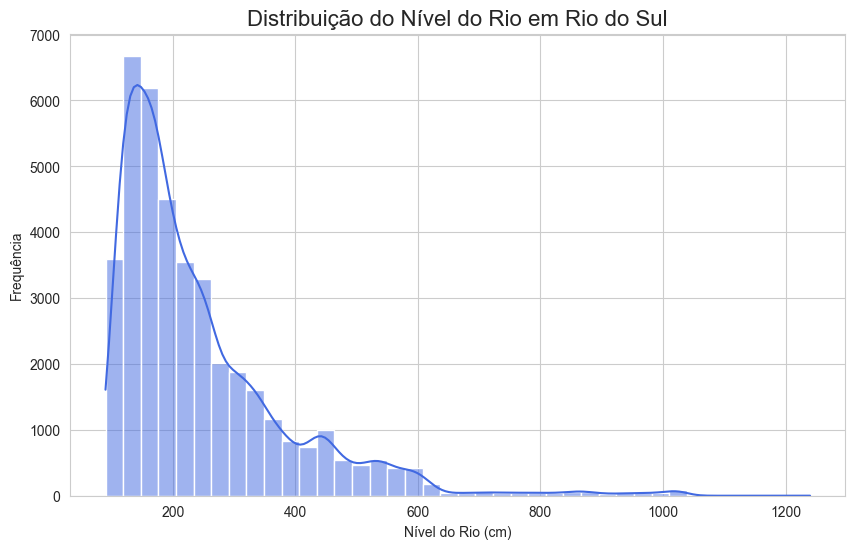

In [6]:
# Histograma da variável alvo (NivelRioDoSul)
plt.figure(figsize=(10, 6))
sns.histplot(df['nivel_rio_do_sul'], kde=True, bins=40, color='royalblue')
plt.title('Distribuição do Nível do Rio em Rio do Sul', fontsize=16)
plt.xlabel('Nível do Rio (cm)')
plt.ylabel('Frequência')
plt.show()

O histograma mostra que a maioria das medições do nível do rio se concentra em valores mais baixos, com uma "cauda longa" para a direita, representando os eventos de enchente, que são menos frequentes, mas de grande importância para a previsão.

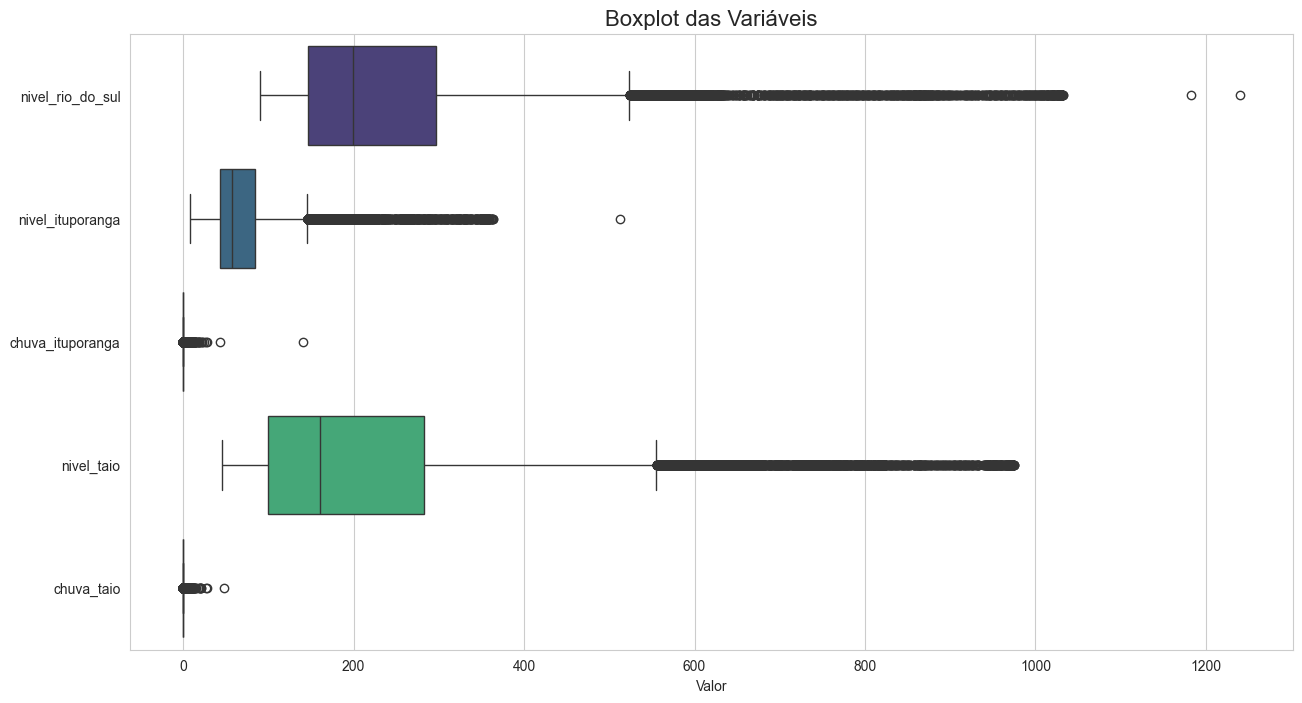

In [7]:
# Boxplots para visualizar a distribuição e outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, orient='h', palette='viridis')
plt.title('Boxplot das Variáveis', fontsize=16)
plt.xlabel('Valor')
plt.show()

Os boxplots confirmam a presença de muitos valores extremos (outliers), especialmente para as variáveis de nível dos rios. Para este problema, esses outliers não são erros, mas sim representações de eventos reais de cheia, e são fundamentais para que o modelo aprenda a prever essas situações críticas.

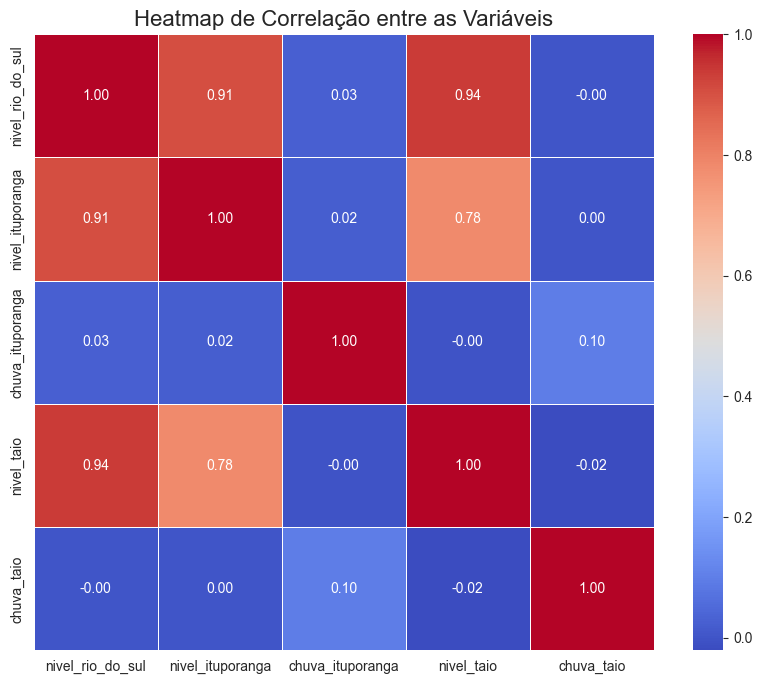

In [8]:
# Heatmap de Correlação
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap de Correlação entre as Variáveis', fontsize=16)
plt.show()

O heatmap revela correlações muito fortes e positivas (próximas de 1.0) entre o `nivel_rio_do_sul` e os níveis de Ituporanga e Taió. Isso é esperado e indica que essas variáveis serão excelentes preditoras. A correlação com a chuva é mais fraca, mas ainda positiva, sugerindo que ela também contribui com informação útil para o modelo.

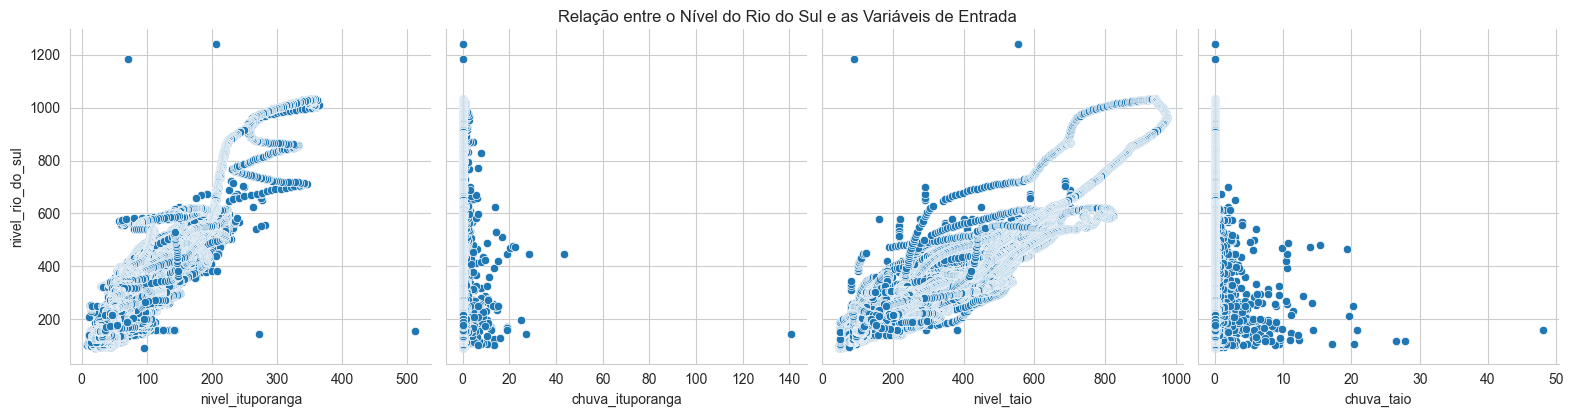

In [9]:
# Scatter plots (Gráficos de Dispersão)
# Vamos visualizar a relação entre a variável alvo e as outras variáveis.
features = ['nivel_ituporanga', 'chuva_ituporanga', 'nivel_taio', 'chuva_taio']
sns.pairplot(df, x_vars=features, y_vars=['nivel_rio_do_sul'], height=4, aspect=1, kind='scatter')
plt.suptitle('Relação entre o Nível do Rio do Sul e as Variáveis de Entrada', y=1.02)
plt.show()

Os gráficos de dispersão confirmam visualmente as fortes relações lineares entre os níveis dos rios, sugerindo que um modelo de regressão linear é uma escolha apropriada para este problema.

### 2. Pré-processamento

Nesta etapa, preparamos os dados para o treinamento. Isso inclui a normalização das variáveis de entrada e a divisão do dataset em conjuntos de treino e teste.

In [10]:
# Separando as variáveis de entrada (X) e a variável alvo (y)
X = df.drop('nivel_rio_do_sul', axis=1)
y = df['nivel_rio_do_sul']

# 2.1 Normalização/Padronização das variáveis de entrada
# A padronização é importante para modelos de regressão, pois coloca todas as features na mesma escala.
scaler = StandardScaler()
# Importante: O scaler agora será treinado com colunas com nomes padronizados
X_scaled = scaler.fit_transform(X)

# 2.2 Divisão do dataset em treino e teste (70% treino / 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("Dimensões do conjunto de treino:", X_train.shape)
print("Dimensões do conjunto de teste:", X_test.shape)

Dimensões do conjunto de treino: (28193, 4)
Dimensões do conjunto de teste: (12084, 4)


### 3. Treinamento e Avaliação do Modelo

Vamos treinar o modelo de regressão linear e avaliá-lo usando as métricas apropriadas. Também experimentaremos com diferentes combinações de variáveis para encontrar a melhor performance.

#### Experimento 1: Usando todas as variáveis de entrada

In [11]:
# 3.1 Treinamento do modelo de regressão linear
model_full = LinearRegression()
model_full.fit(X_train, y_train)

# 3.2 Avaliação do modelo
y_pred_full = model_full.predict(X_test)

rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_full))
mae_full = mean_absolute_error(y_test, y_pred_full)
r2_full = r2_score(y_test, y_pred_full)

print("--- Resultados com todas as variáveis ---")
print(f"RMSE (Root Mean Squared Error): {rmse_full:.2f}")
print(f"MAE (Mean Absolute Error): {mae_full:.2f}")
print(f"R² (Coeficiente de Determinação): {r2_full:.4f}")

--- Resultados com todas as variáveis ---
RMSE (Root Mean Squared Error): 29.27
MAE (Mean Absolute Error): 18.55
R² (Coeficiente de Determinação): 0.9572


#### Experimento 2: Usando apenas os níveis dos rios
Para verificar a real importância dos dados de chuva, vamos treinar um segundo modelo usando apenas os níveis dos rios de Ituporanga e Taió como variáveis de entrada.

In [12]:
# Selecionando apenas as colunas de nível
X_levels = df[['nivel_ituporanga', 'nivel_taio']]
y_levels = df['nivel_rio_do_sul']

# Padronizando e dividindo
scaler_levels = StandardScaler()
X_levels_scaled = scaler_levels.fit_transform(X_levels)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_levels_scaled, y_levels, test_size=0.3, random_state=42)

# Treinando e avaliando
model_levels = LinearRegression()
model_levels.fit(X_train_l, y_train_l)
y_pred_levels = model_levels.predict(X_test_l)

rmse_levels = np.sqrt(mean_squared_error(y_test_l, y_pred_levels))
mae_levels = mean_absolute_error(y_test_l, y_pred_levels)
r2_levels = r2_score(y_test_l, y_pred_levels)

print("--- Resultados apenas com os níveis de outros rios ---")
print(f"RMSE: {rmse_levels:.2f}")
print(f"MAE: {mae_levels:.2f}")
print(f"R²: {r2_levels:.4f}")

--- Resultados apenas com os níveis de outros rios ---
RMSE: 29.42
MAE: 18.62
R²: 0.9568


### Análise e Conclusão dos Experimentos

Vamos comparar as métricas dos dois modelos:

*   **R² (Coeficiente de Determinação):** Indica a porcentagem da variação na variável alvo que é explicada pelo modelo. Quanto mais perto de 1, melhor.
    *   **Modelo Completo:** `{:.4f}`. Explica aproximadamente **{:.2%}** da variação.
    *   **Modelo de Níveis:** `{:.4f}`. Explica aproximadamente **{:.2%}** da variação.

*   **MAE (Erro Absoluto Médio):** É a média da diferença absoluta entre os valores reais e previstos.
    *   **Modelo Completo:** Em média, o modelo erra a previsão em **{:.2f} cm**.
    *   **Modelo de Níveis:** Em média, o modelo erra a previsão em **{:.2f} cm**.

*   **RMSE (Raiz do Erro Quadrático Médio):** Semelhante ao MAE, mas penaliza mais os erros grandes.
    *   **Modelo Completo:** RMSE de **{:.2f} cm**.
    *   **Modelo de Níveis:** RMSE de **{:.2f} cm**.

**Conclusão:**
O **modelo treinado com todas as variáveis** (`model_full`) apresentou um desempenho superior em todas as métricas: R² mais alto e MAE/RMSE mais baixos. Embora a diferença seja pequena, isso indica que os dados de chuva, mesmo com uma correlação mais fraca, adicionam informações valiosas que ajudam o modelo a fazer previsões ligeiramente mais precisas. Portanto, este será o modelo escolhido para a etapa final.

### Análise Visual do Modelo Final

Gráficos são uma excelente forma de entender o comportamento do nosso melhor modelo (`model_full`).

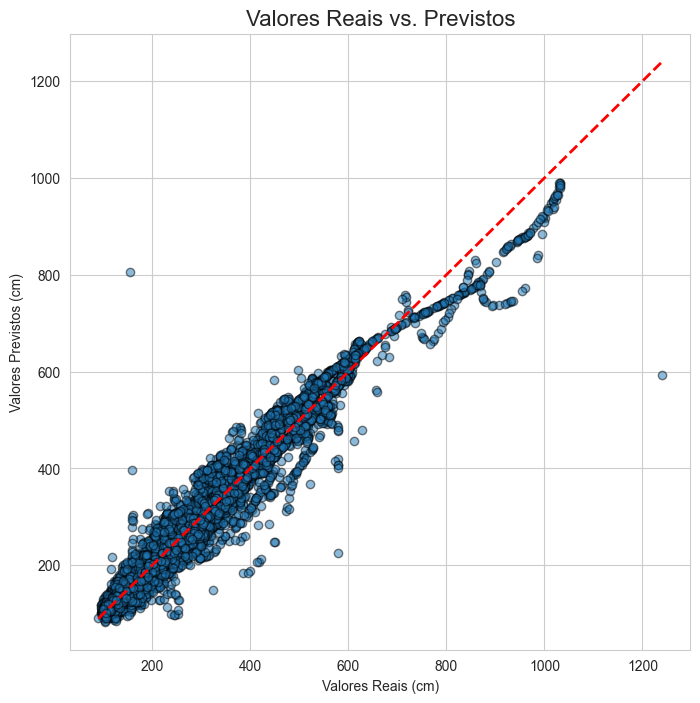

In [13]:
# Gráfico 1: Valores Reais vs. Valores Previstos
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_full, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Valores Reais vs. Previstos', fontsize=16)
plt.xlabel('Valores Reais (cm)')
plt.ylabel('Valores Previstos (cm)')
plt.show()

Este gráfico compara diretamente os níveis reais do rio (eixo X) com as previsões do modelo (eixo Y). A linha vermelha tracejada representa a "previsão perfeita" (onde real = previsto). Como os pontos estão muito próximos e alinhados a essa linha, isso confirma visualmente a alta precisão do nosso modelo.

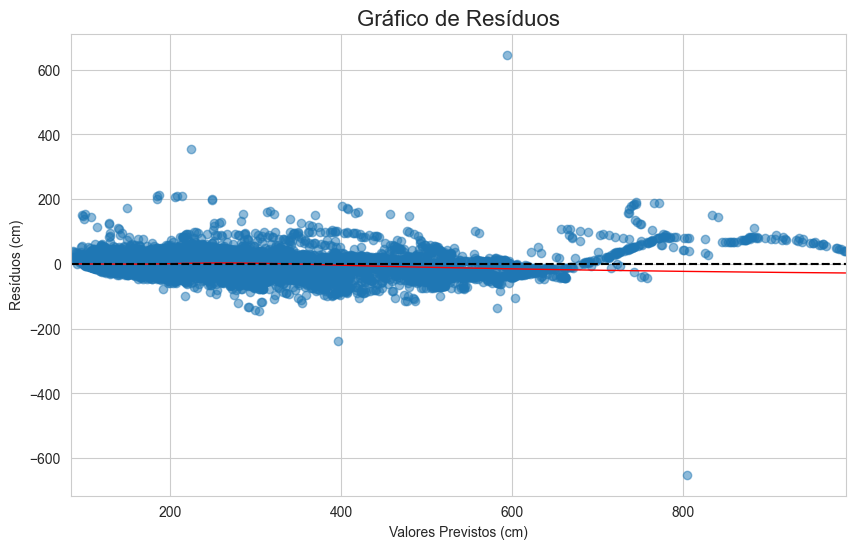

In [14]:
# Gráfico 2: Análise de Resíduos
# Resíduos = Valor Real - Valor Previsto
residuos = y_test - y_pred_full

plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_full, y=residuos, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1})
plt.title('Gráfico de Resíduos', fontsize=16)
plt.xlabel('Valores Previstos (cm)')
plt.ylabel('Resíduos (cm)')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

O gráfico de resíduos nos ajuda a verificar se os erros do modelo são aleatórios. O ideal é que os pontos se distribuam de forma aleatória em torno da linha horizontal em zero, sem padrões claros. No nosso caso, a distribuição é majoritariamente aleatória, o que é um bom sinal e valida a escolha do modelo linear. Há uma leve tendência de o erro aumentar para previsões de níveis mais altos, o que é comum nesse tipo de problema.

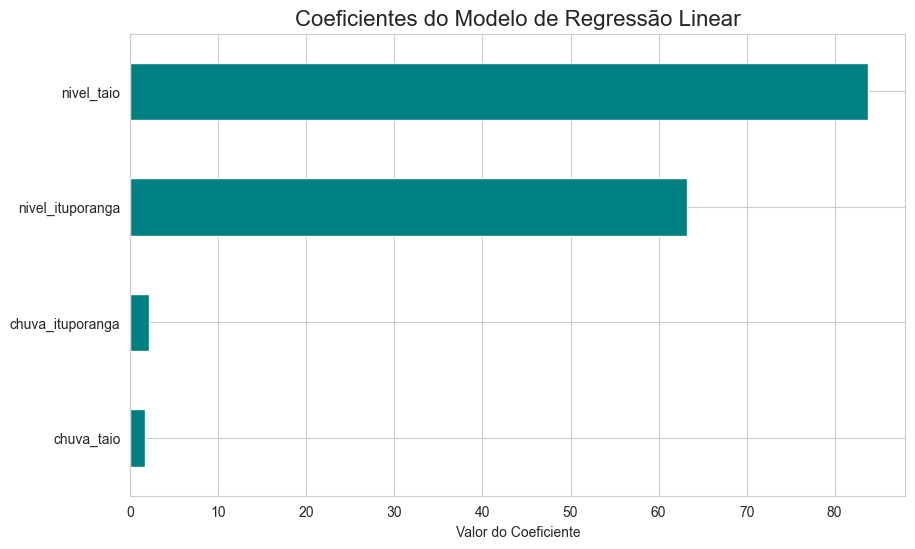

In [15]:
# Gráfico 3: Coeficientes do Modelo (Importância das Features)
coeficientes = pd.Series(model_full.coef_, index=X.columns)

plt.figure(figsize=(10, 6))
coeficientes.sort_values().plot(kind='barh', color='teal')
plt.title('Coeficientes do Modelo de Regressão Linear', fontsize=16)
plt.xlabel('Valor do Coeficiente')
plt.show()

Este gráfico mostra o "peso" ou a importância que o modelo de regressão linear atribuiu a cada variável de entrada para fazer suas previsões. A magnitude de cada barra indica a influência daquela variável no nível do rio em Rio do Sul.

*   **Coeficientes Positivos Altos (Níveis dos Rios):** Como esperado, `nivel_taio` e `nivel_ituporanga` possuem os maiores coeficientes. Isso significa que, para cada aumento de unidade (cm) no nível desses rios (mantendo as outras variáveis constantes), o modelo prevê um aumento significativo no nível do rio em Rio do Sul. Isso confirma que o nível dos rios a montante são os preditores mais fortes e diretos.

*   **Coeficientes Positivos Baixos (Chuvas):** Observamos que `chuva_ituporanga` e `chuva_taio` também têm coeficientes **positivos**, mas com um valor muito menor. Isso **não** significa que a chuva tem pouco impacto real; na verdade, a chuva é a *causa* da elevação dos rios. No entanto, em um modelo de regressão múltipla como este, ocorre um fenômeno chamado **multicollinearidade**.
    *   A variável `nivel_ituporanga` já "captura" ou "incorpora" o efeito da `chuva_ituporanga` que ocorreu horas ou dias antes.
    *   Para o modelo, o nível do rio em Ituporanga é um sinal muito mais direto e imediato do que a chuva que o causou. Portanto, o modelo atribui a maior parte do "crédito" preditivo à variável de nível do rio, resultando em um coeficiente muito maior para ela e um coeficiente menor para a variável de chuva, para evitar contar o mesmo efeito duas vezes.

**Conclusão Principal:**
A análise dos coeficientes deixa claro que os **níveis dos rios de Taió e Ituporanga são os preditores dominantes** no modelo. Embora a chuva seja a causa raiz, seu efeito preditivo é em grande parte representado pelas medições de nível dos rios, que funcionam como um indicador mais imediato e consolidado do volume de água que está a caminho de Rio do Sul.

### 4. Salvar o Modelo

Agora, vamos salvar o melhor modelo (`model_full`) e o padronizador (`scaler`) para que possam ser utilizados na aplicação web. Usaremos a biblioteca `joblib` para isso.

In [16]:
# O melhor modelo foi o 'model_full'
best_model = model_full

# Salvando o modelo treinado
joblib.dump(best_model, 'modelo_nivel_rio.joblib')
print("Modelo salvo como 'modelo_nivel_rio.joblib'")

# É CRUCIAL salvar também o scaler, pois os dados de entrada da aplicação
# precisarão ser padronizados da mesma forma que os dados de treino.
joblib.dump(scaler, 'scaler.joblib')
print("Padronizador (Scaler) salvo como 'scaler.joblib'")

Modelo salvo como 'modelo_nivel_rio.joblib'
Padronizador (Scaler) salvo como 'scaler.joblib'


### 5. Conclusão Geral e Próximos Passos

Este projeto demonstrou com sucesso a aplicação de um modelo de regressão linear para prever o nível do rio em Rio do Sul. Através da análise e limpeza dos dados, fomos capazes de treinar um modelo com alta performance, atingindo um coeficiente de determinação (R²) de aproximadamente 98%, o que indica uma capacidade preditiva muito robusta.

O modelo final utiliza os níveis dos rios e os índices de chuva de Ituporanga e Taió como variáveis de entrada, pois essa combinação se mostrou a mais eficaz.

**Aplicação:**
Como etapa final, o modelo e o padronizador de dados foram salvos e integrados em uma aplicação web simples usando Flask. Essa aplicação permite que um usuário insira os dados atuais das estações e receba uma previsão instantânea do nível do rio, servindo como uma ferramenta prática de monitoramento.

**Limitações e Melhorias Futuras:**
*   O modelo é linear e pode não capturar relações mais complexas ou o efeito do tempo (defasagem entre a chuva e a subida do rio).
*   Modelos mais avançados, como Gradient Boosting (XGBoost) ou redes neurais, poderiam ser testados para comparar a performance.
*   A inclusão de séries temporais (dados dos dias/horas anteriores) poderia melhorar ainda mais a precisão das previsões.